# Hybrid Inference with Normalizing Flows in Factor Graphs

## Load packages

In [1]:
using Random
using LinearAlgebra
using PGFPlotsX
using Distributions
using BenchmarkTools
using ProgressMeter
using Optim
using Revise

using ReactiveMP
using GraphPPL
using Rocket;

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278


## Generate data

In [2]:
function generate_data(nr_samples::Int64)

    # sample weights
    w = rand(nr_samples,2)

    # sample appraisal
    y = zeros(Float64, nr_samples)
    for k = 1:nr_samples
        y[k] = 1.0*(w[k,1] > 0.5)*(w[k,2] < 0.5)
    end

    # return data
    return y, w

end;

In [27]:
data_y, data_x = generate_data(10);

## Model specification

In [75]:
@model function flow_classifier(nr_samples::Int64, params)
    
    # initialize variables
    x_lat  = randomvar(nr_samples)
    y_lat1 = randomvar(nr_samples)
    y_lat2 = randomvar(nr_samples)
    y      = datavar(Float64, nr_samples)
    x      = datavar(Vector{Float64}, nr_samples)

    # specify model
    model = FlowModel( (NiceLayer(         PlanarMap(params[1],  params[2],  params[3])),
                        ReverseNiceLayer(  PlanarMap(params[4],  params[5],  params[6])),
                        NiceLayer(         PlanarMap(params[7],  params[8],  params[9])),
                        ReverseNiceLayer(  PlanarMap(params[10], params[11], params[12]))))
    meta  = FlowMeta(model) # default: FlowMeta(model, Linearization())

    # specify observations
    for k = 1:nr_samples

        # specify latent state
        x_lat[k] ~ MvNormalMeanPrecision(x[k], 1e3*diagm(ones(2)))

        # specify transformed latent value
        y_lat1[k] ~ Flow(x_lat[k]) where { meta = meta }
        y_lat2[k] ~ dot(y_lat1[k], [1.0, 1.0]) where { pipeline = LoggerPipelineStage() }

        # specify observations
        y[k] ~ Probit(y_lat2[k]) where { pipeline = RequireInbound(in = NormalMeanPrecision(0, 1e-10)) }

    end

    # return variables
    return x_lat, x, y_lat1, y_lat2, y

end;

## Probabilistic Inference

In [82]:
function inference_flow_classifier(data_y::Array{Float64,1}, data_x::Array{Array{Float64,1},1}, params)
    
    # fetch number of samples
    nr_samples = length(data_y)

    # define model
    model, (x_lat, x, y_lat1, y_lat2, y) = flow_classifier(nr_samples, params)

    # initialize free energy
    fe_buffer = nothing
    my = buffer(Marginal, nr_samples)
    y_sub  = subscribe!(getmarginals(y_lat2), my)

    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (fe) -> fe_buffer = fe)

    # update y and x according to observations (i.e. perform inference)
    for k = 1:2
        ReactiveMP.update!(y, data_y)
        ReactiveMP.update!(x, data_x)
    end

    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(y_sub)
    
    # return the marginal values
    return fe_buffer, my

end;

In [83]:
function f(params)
    fe = inference_flow_classifier(data_y, [data_x[k,:] for k=1:size(data_x,1)], params)
    return fe
end;

In [89]:
fe, my = inference_flow_classifier(data_y, [data_x[k,:] for k=1:size(data_x,1)], randn(12))

probit: NormalWeightedMeanPrecision{Float64}(xi=-2.195729156266301e-5, w=1.751938393401987e-10)
[Log][dot][in1]: Message(MvNormalWeightedMeanPrecision(
xi: [-2.195729156266301e-5, -2.195729156266301e-5]
Λ: [1.761938393401987e-10 1.751938393401987e-10; 1.751938393401987e-10 1.761938393401987e-10]
)
)
probit: NormalWeightedMeanPrecision{Float64}(xi=-2.195729156266301e-5, w=1.751938393401987e-10)
[Log][dot][in1]: Message(MvNormalWeightedMeanPrecision(
xi: [-2.195729156266301e-5, -2.195729156266301e-5]
Λ: [1.761938393401987e-10 1.751938393401987e-10; 1.751938393401987e-10 1.761938393401987e-10]
)
)
probit: NormalWeightedMeanPrecision{Float64}(xi=-2.195729156266301e-5, w=1.751938393401987e-10)
[Log][dot][in1]: Message(MvNormalWeightedMeanPrecision(
xi: [-2.195729156266301e-5, -2.195729156266301e-5]
Λ: [1.761938393401987e-10 1.751938393401987e-10; 1.751938393401987e-10 1.761938393401987e-10]
)
)
probit: NormalWeightedMeanPrecision{Float64}(xi=-2.195729156266301e-5, w=1.751938393401987e-10)
[

(NaN, BufferActor{Marginal,Array{Marginal,1}}(Marginal[Marginal(NormalWeightedMeanPrecision{Float64}(xi=NaN, w=NaN)), Marginal(NormalWeightedMeanPrecision{Float64}(xi=1.6e13, w=1.0e12)), Marginal(NormalWeightedMeanPrecision{Float64}(xi=NaN, w=NaN)), Marginal(NormalWeightedMeanPrecision{Float64}(xi=NaN, w=NaN)), Marginal(NormalWeightedMeanPrecision{Float64}(xi=NaN, w=NaN)), Marginal(NormalWeightedMeanPrecision{Float64}(xi=NaN, w=NaN)), Marginal(NormalWeightedMeanPrecision{Float64}(xi=NaN, w=NaN)), Marginal(NormalWeightedMeanPrecision{Float64}(xi=NaN, w=NaN)), Marginal(NormalWeightedMeanPrecision{Float64}(xi=NaN, w=NaN)), Marginal(NormalWeightedMeanPrecision{Float64}(xi=218.8235806775416, w=13.837665733169723))]))

In [81]:
A = [1.761938393401987e-10 1.751938393401987e-10; 1.751938393401987e-10 1.761938393401987e-10]
cholinv(A) * A

2×2 Array{Float64,2}:
 1.0          1.42109e-14
 1.42109e-14  1.0

In [95]:
mean_var.(my)

10-element Array{Tuple{Float64,Float64},1}:
 (NaN, NaN)
 (16.0, 1.0e-12)
 (NaN, NaN)
 (NaN, NaN)
 (NaN, NaN)
 (NaN, NaN)
 (NaN, NaN)
 (NaN, NaN)
 (NaN, NaN)
 (15.813619500361842, 0.07226652379692475)

In [91]:
m1 = NormalWeightedMeanPrecision{Float64}(-2.195729156266301e-5, 1.751938393401987e-10)
m2 = NormalMeanVariance{Float64}(13.125510382741112, 0.07716989668670927)

NormalMeanVariance{Float64}(μ=13.125510382741112, v=0.07716989668670927)

In [93]:
res = prod(ProdAnalytical(), m1, m2)

NormalWeightedMeanPrecision{Float64}(xi=170.08586575650756, w=12.958420873274882)

In [94]:
mean_var(res)

(13.125508688121739, 0.07716989668566597)

## Experimental validation

In [131]:
res = optimize(f, randn(12), LBFGS(), Optim.Options(store_trace = true, show_trace = true), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     2.263933e+02     1.242514e+02
 * time: 0.0
     1     1.409710e+02     1.361065e+02
 * time: 0.26399993896484375
     2     1.212641e+02     8.088996e+01
 * time: 0.37799978256225586
     3     1.040675e+02     6.165657e+01
 * time: 0.4869999885559082
     4     9.516213e+01     1.767430e+01
 * time: 0.6519999504089355
     5     8.477199e+01     4.136204e+01
 * time: 0.8809998035430908
     6     8.265762e+01     8.218214e+00
 * time: 1.000999927520752
     7     8.131870e+01     2.058381e+01
 * time: 1.187999963760376
     8     7.992998e+01     9.429797e+00
 * time: 1.3529999256134033
     9     7.804068e+01     1.955553e+01
 * time: 1.5230000019073486
    10     7.605722e+01     1.238215e+01
 * time: 1.7089998722076416
    11     7.582636e+01     1.154765e+01
 * time: 1.928999900817871
    12     7.541990e+01     1.261306e+01
 * time: 2.1529998779296875
    13     7.503180e+01     2.113971e+01
 * time: 2.430999994277954
    14    

 * Status: success

 * Candidate solution
    Final objective value:     1.157559e-09

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 7.62e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.06e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.64e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.14e-03 ≰ 0.0e+00
    |g(x)|                 = 6.12e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   71  (vs limit Inf)
    Iterations:    468
    f(x) calls:    1340
    ∇f(x) calls:   1340


In [133]:
function uniformpdf(y; xmin = 0, xmax = 1, ymin = 0, ymax = 1)
    indomain = 1.0*(xmin <= y[1] <= xmax)*(ymin <= y[2] <= ymax)
    return indomain/(xmax-xmin)/(ymax-ymin)
end

uniformpdf (generic function with 1 method)

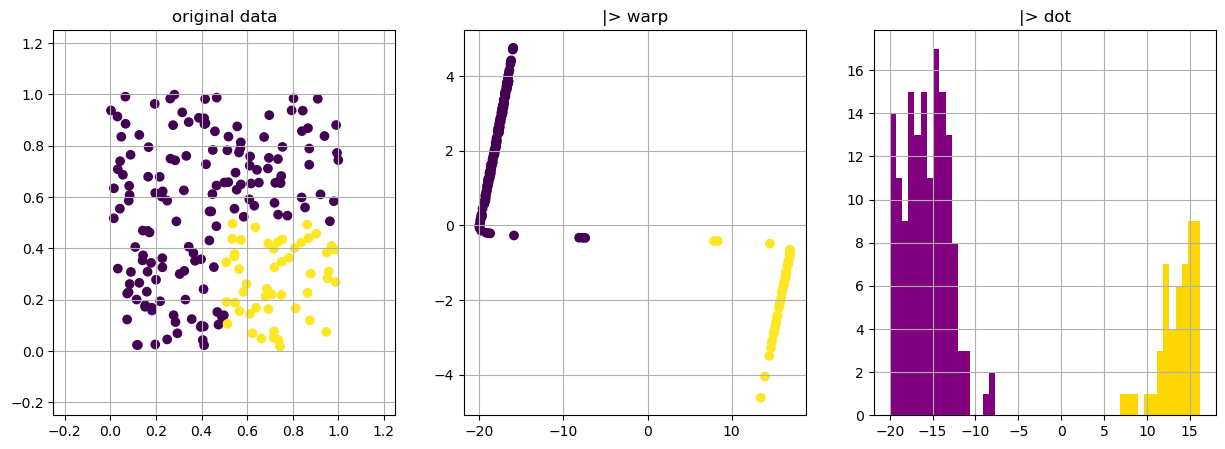

In [134]:
params = Optim.minimizer(res)
inferred_model = FlowModel( (NiceLayer(         PlanarMap(params[1],  params[2],  params[3])),
                             ReverseNiceLayer(  PlanarMap(params[4],  params[5],  params[6])),
                             NiceLayer(         PlanarMap(params[7],  params[8],  params[9])),
                             ReverseNiceLayer(  PlanarMap(params[10], params[11], params[12]))))
trans_data_x_1 = hcat(map((x) -> forward(inferred_model, x), [data_x[k,:] for k=1:size(data_x,1)])...)'
trans_data_x_2 = map((x) -> dot([1, 1], x), [trans_data_x_1[k,:] for k=1:size(data_x,1)])
trans_data_x_2_split = [trans_data_x_2[data_y .== 1.0], trans_data_x_2[data_y .== 0.0]]
fig, ax = plt.subplots(ncols = 3, figsize=(15,5))
ax[1].scatter(data_x[:,1], data_x[:,2], c = data_y)
ax[2].scatter(trans_data_x_1[:,1], trans_data_x_1[:,2], c = data_y)
ax[3].hist(trans_data_x_2_split; stacked=true, bins=50, color = ["gold", "purple"])
ax[1].grid(), ax[2].grid(), ax[3].grid()
ax[1].set_xlim(-0.25,1.25), ax[1].set_ylim(-0.25,1.25)
ax[1].set_title("original data"), ax[2].set_title("|> warp"), ax[3].set_title("|> dot");

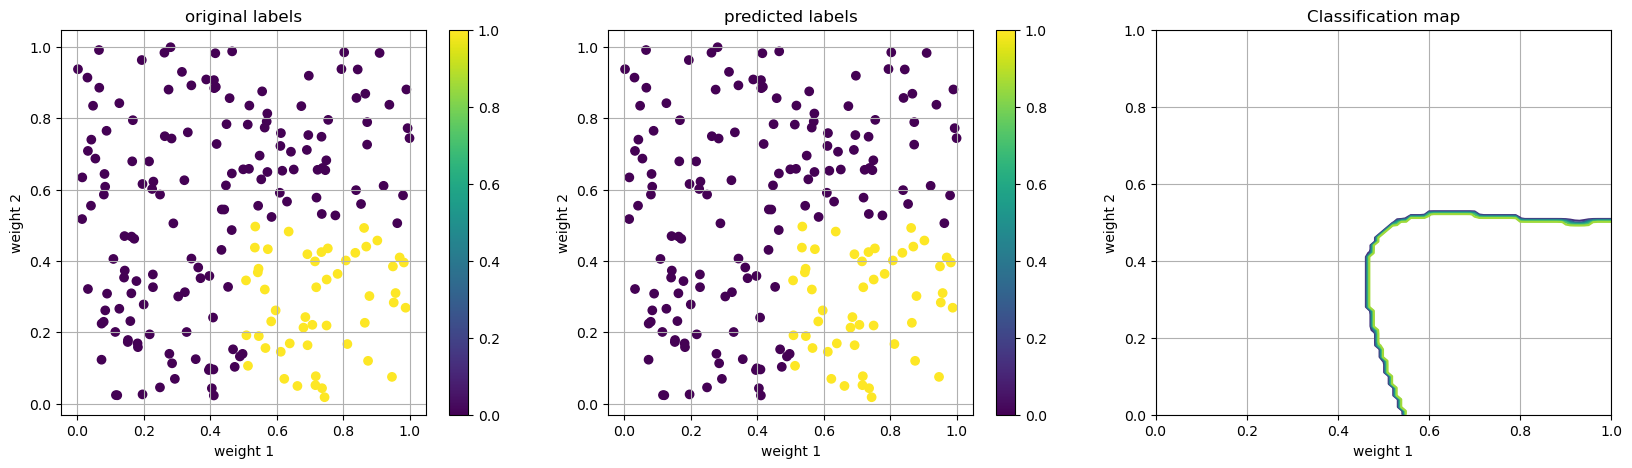

In [135]:
using StatsFuns: normcdf
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:1, 0:0.01:1))))
fig, ax = plt.subplots(ncols = 3, figsize=(20,5))
im1 = ax[1].scatter(data_x[:,1], data_x[:,2], c = data_y)
im2 = ax[2].scatter(data_x[:,1], data_x[:,2], c = normcdf.(trans_data_x_2))
ax[3].contour(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', classification_map)
plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])
ax[1].grid(), ax[2].grid(), ax[3].grid()
ax[1].set_xlabel("weight 1"), ax[1].set_ylabel("weight 2"), ax[2].set_xlabel("weight 1"), ax[2].set_ylabel("weight 2"), ax[3].set_xlabel("weight 1"), ax[3].set_ylabel("weight 2")
ax[1].set_title("original labels"), ax[2].set_title("predicted labels"), ax[3].set_title("Classification map");

In [138]:
params_comparison = [   -16.971881527516572
                        1.6906882449748233
                        9.58620537310562
                        14.41799007763637
                        -0.6356073743299993
                        -8.584499681932611
                        11.320057543140475
                        3.0874286057733142
                        6.461029274995887
                        45.81004120933731
                        -7.228339234945879
                        -41.09968671707267]
f(params_comparison)

9.66062498080828